In [1]:
%%capture
! pip install umap-learn

In [19]:
from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
%load_ext tensorboard

import umap

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## VAE

In [72]:
class VAE(tf.keras.models.Model):
  def __init__(self, encoder, decoder, beta=0.1, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.beta = beta
    self.loss_total = tf.keras.metrics.Mean("loss_total")
    self.loss_rebuild = tf.keras.metrics.Mean("loss_rebuild")
    self.loss_kl = tf.keras.metrics.Mean("loss_kl")

  @property
  def metrics(self):
    return [
        self.loss_total,
        self.loss_rebuild,
        self.loss_kl,
    ]

  def call(self, inputs):
    mu, log_sigma, z = self.encoder(inputs)
    x_hat = self.decoder(z)
    return mu, log_sigma, x_hat

  def train_step(self, data):
    with tf.GradientTape() as tape:
      mu, log_sigma, x_hat = self(data)
      # loss_rebuild = tf.reduce_mean(tf.keras.losses.mean_squared_error(data, x_hat))
      loss_rebuild = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, x_hat, axis=(1, 2, 3)))
      loss_kl = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + log_sigma - tf.square(mu) - tf.exp(log_sigma)), axis=1))
      loss_total = loss_rebuild + self.beta * loss_kl

    grads = tape.gradient(loss_total, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.loss_total.update_state(loss_total)
    self.loss_rebuild.update_state(loss_rebuild)
    self.loss_kl.update_state(loss_kl)

    return {m.name: m.result() for m in self.metrics}

### Sampling

In [73]:
class Sample(tf.keras.layers.Layer):
  """Sample encoding.

  Draw a multivariate normal random vector with specified mean and log variance.
  The covariance structure is assumed diagonal.

  """
  def call(self, inputs):
    mu, log_sigma = inputs
    eps = tf.keras.backend.random_normal(shape=tf.shape(mu))
    z = mu + tf.exp(0.5 * log_sigma) * eps
    return z

### Encoder

In [126]:
def build_encoder(
  input_dim: int=28,
  latent_dim: int=128,
  num_blocks: int=2,
  base_filters: int=32,
  kernel_size: int=3,
) -> Dict[str, Any]:
  """Build encoder.

  Notes:
    * Assumes gray-scale images.

  Args:
    input_dim: Input dimension.
    latent_dim: Dimension of embedding space.
    num_blocks: Number of convolutional blocks.
    base_filters: Number of filters in the base convolution, doubles each block.
    kernel_size: Size of convolution kernel.

  """

  # Input.
  input = tf.keras.layers.Input(shape=(input_dim, input_dim, 1), name="input")
  h = input

  # Convolutional blocks.
  for i in range(num_blocks):
    h = tf.keras.layers.Conv2D(
        base_filters * (2 ** i),
        kernel_size,
        padding="same",
        name=f"conv{i}"
      )(h)
    width = tf.keras.backend.int_shape(h)[1]
    if (width % 2 == 0):
      h = tf.keras.layers.MaxPool2D(name=f"pool{i}")(h)
    else:
      h = tf.keras.layers.MaxPool2D(pool_size=1, name=f"pool{i}")(h)
    h = tf.keras.layers.BatchNormalization(name=f"norm{i}")(h)
    h = tf.keras.layers.ELU(name=f"elu{i}")(h)

  # Flatten last convolutional layer for input into mu and log_sigma. Save
  # penultimate shape for use by decoder.
  last_conv_shape = tf.keras.backend.int_shape(h)
  h = tf.keras.layers.Flatten(name="flat")(h)

  # Mean, log variance, stochastic embedding.
  mu = tf.keras.layers.Dense(latent_dim, name="mu")(h)
  log_sigma = tf.keras.layers.Dense(latent_dim, name="log_sigma")(h)
  z = Sample()([mu, log_sigma])

  # Overall model.
  encoder = tf.keras.models.Model(input, [mu, log_sigma, z], name="encoder")
  return {
    "model": encoder,
    "input_shape": tf.keras.backend.int_shape(input),
    "last_conv_shape": last_conv_shape[1:],
  }

### Decoder

In [127]:
def build_decoder(
  last_conv_shape: Tuple[int],
  output_dim: int=28,
  latent_dim: int=128,
  num_blocks: int=2,
  kernel_size: int=3,
) -> tf.keras.Model:
  """Build decoder.

  Args:
    last_conv_shape: Dimension of output from the last convolutional layer
      of the encoder.
    output_dim: Dimension of the reconstructed image.
    latent_dim: Dimension of embedding space.
    num_blocks: Number of transpose convolutional blocks; should match
      the encoder.
    kernel_size: Size of transposed convolution kernel.

  """

  input = tf.keras.layers.Input(shape=(latent_dim,), name="input")
  h = tf.keras.layers.Dense(np.prod(last_conv_shape), name="dense1")(input)
  h = tf.keras.layers.Reshape(last_conv_shape, name="reshape")(h)

  # Transposed convolutions.
  base_filters = last_conv_shape[2]
  for i in range(num_blocks):
    width = tf.keras.backend.int_shape(h)[1]
    if width * 2 > output_dim:
      strides = 1
    else:
      strides = 2
    h = tf.keras.layers.Conv2DTranspose(
      base_filters * (2 ** (-i)),
      kernel_size,
      strides=strides,
      padding="same",
      name=f"convt{i}"
    )(h)
    # h = tf.keras.layers.BatchNormalization(name=f"norm{i}")(h)
    h = tf.keras.layers.ELU(name=f"elu{i}")(h)

  # Final output.
  output = tf.keras.layers.Conv2D(
      1, kernel_size, activation="sigmoid", padding="same", name="output")(h)

  decoder = tf.keras.Model(input, output, name="deconder")
  return {
    "model": decoder,
    "output_shape": tf.keras.backend.int_shape(output),
  }

## Example

### Data

In [128]:
def prepare_mnist_data(
  val_frac: float=0.2,
  seed: int=101,
) -> Dict[str, Any]:

  # Load data.
  (x_train_val, y_train_val), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()

  # Standardize.
  x_train_val = x_train_val.astype("float32") / 255.0
  x_test  = x_test.astype("float32")  / 255.0

  # Add channel axis.
  x_train_val = np.expand_dims(x_train_val, axis=-1)
  x_test = np.expand_dims(x_test, axis=-1)

  # Split into training and validation.
  x_train, x_val, y_train, y_val = \
    train_test_split(
      x_train_val,
      y_train_val,
      test_size=val_frac,
      random_state=seed,
    )

  # Output.
  return {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
  }


In [129]:
data = prepare_mnist_data()

### Model

In [130]:
# Construct encoder.
encoder_dict = build_encoder()
encoder = encoder_dict["model"]
input_shape = encoder_dict["input_shape"]
last_conv_shape = encoder_dict["last_conv_shape"]
# encoder.summary()

In [131]:
# Construct deconder.
decoder_dict = build_decoder(last_conv_shape)
decoder = decoder_dict["model"]
output_shape = decoder_dict["output_shape"]
# decoder.summary()

In [132]:
assert input_shape == output_shape, "Input and output shapes do not match."

In [174]:
vae = VAE(encoder, decoder, beta=0.0001)
vae.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
)

### Callbacks

In [175]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath="logs/base_vae/checkpoints/",
  monitor="loss"
)

In [176]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir="logs/base_vae/",
  histogram_freq=1,
  write_graph=False,
)

In [177]:
callbacks = [
  checkpoint_callback,
  tensorboard_callback,
]

### Training

In [178]:
#%tensorboard --logdir logs/base_vae/

In [179]:
# Train.
history = vae.fit(
  x=data["x_train"],
  callbacks=callbacks,
  batch_size=128,
  epochs=3,
)

Epoch 1/3
375/375 [==============================] - ETA: 0s - loss_total: 0.5393 - loss_rebuild: 0.2256 - loss_kl: 3136.8711

375/375 [==============================] - 119s 309ms/step - loss_total: 0.5393 - loss_rebuild: 0.2256 - loss_kl: 3136.8711
Epoch 2/3
375/375 [==============================] - ETA: 0s - loss_total: 0.1176 - loss_rebuild: 0.0916 - loss_kl: 260.3642

375/375 [==============================] - 115s 306ms/step - loss_total: 0.1176 - loss_rebuild: 0.0916 - loss_kl: 260.3642
Epoch 3/3
375/375 [==============================] - ETA: 0s - loss_total: 0.1060 - loss_rebuild: 0.0868 - loss_kl: 191.9742

375/375 [==============================] - 127s 339ms/step - loss_total: 0.1060 - loss_rebuild: 0.0868 - loss_kl: 191.9742


## View embeddings

In [180]:
_, _, z_test = vae.encoder(data["x_test"])

In [181]:
# UMAP.
reducer = umap.UMAP()
proj = reducer.fit_transform(z_test)

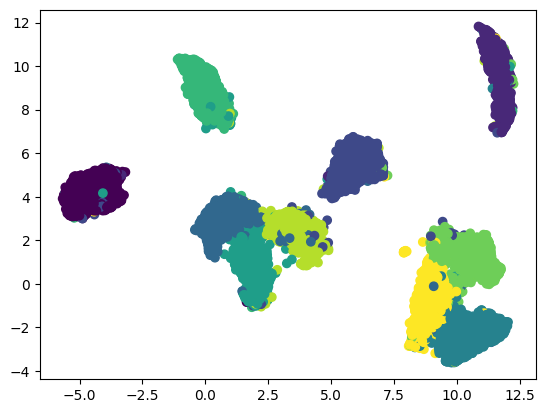

In [182]:
# Plot.
plt.scatter(
  x=proj[:, 0],
  y=proj[:, 1],
  c=data["y_test"]
)

### View reconstructions

In [183]:
def plot_samples(
  x_rebuilt,
  y_test,
) -> None:
  x_rebuilt = x_rebuilt.numpy()
  n_test = x_rebuilt.shape[0]
  draw = np.random.choice(np.arange(n_test), size=9, replace=False)
  x_plot = x_rebuilt[draw, :]
  y_plot = y_test[draw]

  # Plotting.
  fig = plt.figure()
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_plot[i, :])
    plt.title(f"True label: {y_plot[i]}")
    plt.axis("off")
  plt.show()
  return None


In [184]:
x_rebuilt = vae.decoder(z_test)

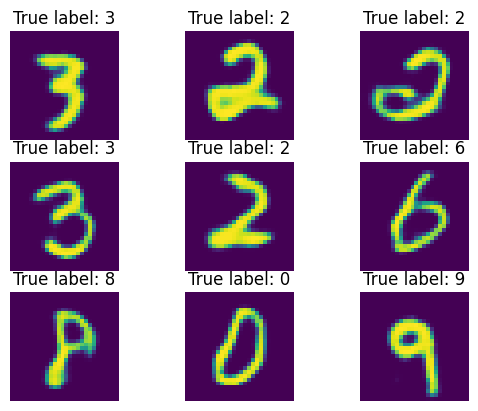

In [185]:
plot_samples(
  x_rebuilt=x_rebuilt,
  y_test=data["y_test"]
)

### Characterize distributions

In [239]:
def characterize_dist(
  x_test: np.ndarray,
  y_test: np.ndarray,
  vae: tf.keras.Model,
  n_sample: int=100
) -> Dict[int, Dict[str, tf.Tensor]]:

  out = {}
  for i in range(9):
    x_i = x_test[y_test == i]
    n_i = x_i.shape[0]
    draw = np.random.choice(np.arange(n_i), size=n_sample, replace=False)
    x_i = x_i[draw, :]

    mu_i, log_var_i, _ = vae.encoder(x_i)
    mu_i = tf.reduce_mean(mu_i, axis=0)
    log_var_i = tf.reduce_mean(log_var_i, axis=0)
    out[i] = {
      "mu": mu_i,
      "log_var": log_var_i,
    }

  return out

In [240]:
dist_param = characterize_dist(data["x_test"], data["y_test"], vae)

### Sample

In [256]:
def generate_image(
    vae: tf.keras.Model,
    label: int,
    dist_param: Dict,
    temp: float=1.0,
  ) -> None:
  """Generate image.

  Args:
    vae: Fitted variational autoencoder.
    label: Class to draw from.
    dist_params: Mean and log-variance vector by class.
    temp: Scalar to increase/descrease generative variance.

  """

  latent_dim = tf.keras.backend.int_shape(vae.decoder.input)[1]

  eps = tf.keras.backend.random_normal(shape=[latent_dim])
  eps = tf.keras.backend.expand_dims(eps, axis=0)

  mu = dist_param[label]["mu"]
  log_var = dist_param[label]["log_var"]
  z = mu + tf.exp(0.5 * log_var * temp) * eps

  out = tf.squeeze(vae.decoder(z), axis=0)
  out = out.numpy()

  plt.imshow(out)
  plt.title(f"Generated image of class {label}.")
  plt.axis("off")
  plt.show()
  return None

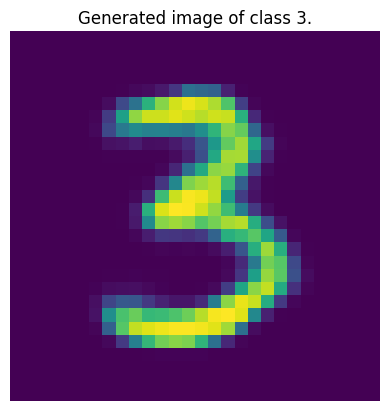

In [284]:
generate_image(
  vae=vae,
  label=3,
  dist_param=dist_param,
)